## 팀 활동
- 유사한 데이터셋을 이용해 비즈니스 가치를 만드는 프로젝트 진행
- 데이터를 활용해 어떤 비즈니스 가치를 만들 수 있을지?
- 데이터셋은 웹 스크래핑으로 만들고, word cloud 제작
    - 프로토타입에 최소 1000개 이상의 데이터 활용
- 프로토타입을 만들고, 만들기 전에 생각했던 비즈니스 가치를 만들 수 있는지 토론

### 프로그램 동작 과정
1. 유니클로 리뷰 크롤링 (ETL)
    - Extract : "https://www.uniqlo.com/kr/api/commerce/v5/ko/products/E465185-000/reviews?limit=5&offset=5&sort=submission_time&httpFailure=true"에서 limit, offset만 변경
        - bs4, requests
        - 제약 사항 : 0 <= limit <= 25이므로 반복문으로 데이터를 가져와서 병합
        - 병합 방식 : 1) Json 형식을 유지하며 병합 (리스트에 append), 2) DataFrame 형태로 변환하여 병합
    - Transform : Json 형식으로 돼있으므로 필요한 데이터를 추출하여 DataFrame 형태로 변환
        - pandas
        - 필요 데이터 : reviewId, heightRange, weightRange, ageRange, purchasedSize, purchasedColorName, comment, title, gender, createDate, rate
    - Load : Tranform된 데이터를 csv 형태로 저장
        - pandas 
2. LLM (생성형 AI)를 활용해 부정, 긍정 단어 추출
    - pip install google-generativeai (gemeni)
    - import google.generativeai as genai
    - LLM Key 발급 및 프롬프트 설정 (부정, 긍정 단어 0 ~ 5개) -> 만약 긍정, 부정이 없다면 0개도 가능
    - 부정, 긍정 단어 데이터는 어떻게 저장해야 할까?
      - 새로운 데이터로 만들고, Key를 reviewId로 해서 JOIN을 통해 데이터 활용 (reviewId, word, neg/pos)
    - 주의 사항 : Key를 Github에 올리지 말 것
3. 부정, 긍정 단어 개수를 기반으로 워드 클라우드 생성
    - pip install wordcloud
    - wordcloud
    - 부정 단어, 긍정 단어 별로 워드 클라우드를 생성해 인사이트 도출 (상위 N개의 단어를 활용)
    - 성별, 나이, 키, 몸무게 등으로 필터링 후 워드 클라우드 수행 (각 분류에 대한 인사이트가 다를 수 있음)

### import

In [3]:
import requests
import pandas as pd
import json
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import ast
from collections import Counter

In [4]:
data_path = '/Users/admin/Desktop/Softeer_DE/data/uniqlo.csv'
emotion_data_path = '/Users/admin/Desktop/Softeer_DE/data/preprocessed_reviews.json'

### Extract
- json으로 데이터 병합, text가 포함돼 있기에 이렇게 하는 게 더 좋을 것이라 판단

In [5]:
limit = 25
offset = 0

header = {"User-Agent": ("Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:125.0) "
                   "Gecko/20100101 Firefox/125.0"),}

url = f'https://www.uniqlo.com/kr/api/commerce/v5/ko/products/E465185-000/reviews?limit={limit}&offset={offset}&sort=submission_time&httpFailure=true'
response = requests.get(url, headers=header).json()
reviews = response['result']['reviews']
offset += 25

# review offset을 초과하면 reviews가 비어 있음
while True:
    url = f'https://www.uniqlo.com/kr/api/commerce/v5/ko/products/E465185-000/reviews?limit={limit}&offset={offset}&sort=submission_time&httpFailure=true'
    response = requests.get(url, headers=header).json()
    tmp_reviews = response['result']['reviews']
    if tmp_reviews == []:
        break
    reviews += tmp_reviews
    offset += 25
    
reviews = json.dumps(reviews, indent=2)
reviews = json.loads(reviews)

### Transform
- text, title을 제외한 데이터를 먼저 추출해서 DataFrame으로 변경
- 데이터 처리
    - createDate의 형식을 date로 변경
    - gender의 "선택하지 않음"을 None으로 설정
    - 모든 컬럼에 대해 ""(빈 문자열)일 경우 None으로 설정
- text와 title은 LLM을 거친 뒤 생성한 DataFrame에 Column 추가

In [6]:
cols = ['reviewId', 'createDate', 'gender', 'heightRange', 'weightRange', 'ageRange', 'purchasedSize', 'purchasedColorName', 'rate']

data = pd.DataFrame(reviews)[cols]
data['gender'] = data['gender'].replace("선택하지않음", None)
for c in data.columns:
    data[c] = data[c].replace("", None)
data['createDate'] = pd.to_datetime(data['createDate'], unit = 's')

# LLM을 통해 긍정, 부정 단어 추출 및 컬럼 추가
emotion_data = pd.read_json(emotion_data_path)

merged_data = pd.merge(left=data, right=emotion_data, how='inner', on='reviewId')

merged_data.head()

,reviewId,createDate,gender,heightRange,weightRange,ageRange,purchasedSize,purchasedColorName,rate,positive_keywords,negative_keywords
0,1441797,2025-07-16 01:13:46,None,None,None,None,M,07 GRAY,5,"[예쁜 색상, 넉넉한 사이즈, 시원함, 빠른 건조]",[]
1,1441791,2025-07-16 00:44:26,None,None,None,None,S,09 BLACK,5,"[좋은 두께감, 부드러움]",[]
2,1441765,2025-07-15 13:29:46,None,None,None,None,L,64 BLUE,5,"[편안함, 빠른 땀 건조, 시원함]",[]
3,1441731,2025-07-15 10:06:28,남성,176 ~ 180cm,76 ~ 80kg,40대,XL,00 WHITE,5,"[만족, 좋은 핏, 오버핏 선호]",[]
4,1441658,2025-07-15 02:14:40,남성,171 ~ 175cm,61 ~ 65kg,30대,M,64 BLUE,5,"[시원함, 통풍, 오버핏 시원함]",[]


In [7]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1053 entries, 0 to 1052
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   reviewId            1053 non-null   int64         
 1   createDate          1053 non-null   datetime64[ns]
 2   gender              494 non-null    object        
 3   heightRange         486 non-null    object        
 4   weightRange         466 non-null    object        
 5   ageRange            464 non-null    object        
 6   purchasedSize       1053 non-null   object        
 7   purchasedColorName  786 non-null    object        
 8   rate                1053 non-null   int64         
 9   positive_keywords   1053 non-null   object        
 10  negative_keywords   1053 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 90.6+ KB


### Load

In [10]:
merged_data.to_csv(data_path)

### Visualization
- 부정, 긍정 단어를 분류하여 문자열 형태로 만들고, wordcloud 생성

In [26]:
data = pd.read_csv(data_path)[cols + ['positive_keywords', 'negative_keywords']]

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1053 entries, 0 to 1052
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   reviewId            1053 non-null   int64 
 1   createDate          1053 non-null   object
 2   gender              494 non-null    object
 3   heightRange         486 non-null    object
 4   weightRange         466 non-null    object
 5   ageRange            464 non-null    object
 6   purchasedSize       1053 non-null   object
 7   purchasedColorName  786 non-null    object
 8   rate                1053 non-null   int64 
 9   positive_keywords   1053 non-null   object
 10  negative_keywords   1053 non-null   object
dtypes: int64(2), object(9)
memory usage: 90.6+ KB


In [16]:
# 필터링
L_data = data[data['purchasedSize'] == 'L']
XL_data = data[data['purchasedSize'] == 'XL']
M_data = data[data['purchasedSize'] == 'M']
XXL_data = data[data['purchasedSize'] == 'XXL']

In [44]:
# 필터링
man_data = data[data['gender'] == '남성']
woman_data = data[data['gender'] == '여성']

In [45]:
# positive
positive_flattened = woman_data['positive_keywords'].apply(ast.literal_eval).explode()
positive_words = [word for word in positive_flattened.dropna()]

# negative
negative_flattened = woman_data['negative_keywords'].apply(ast.literal_eval).explode()
negative_words = [word for word in negative_flattened.dropna()]

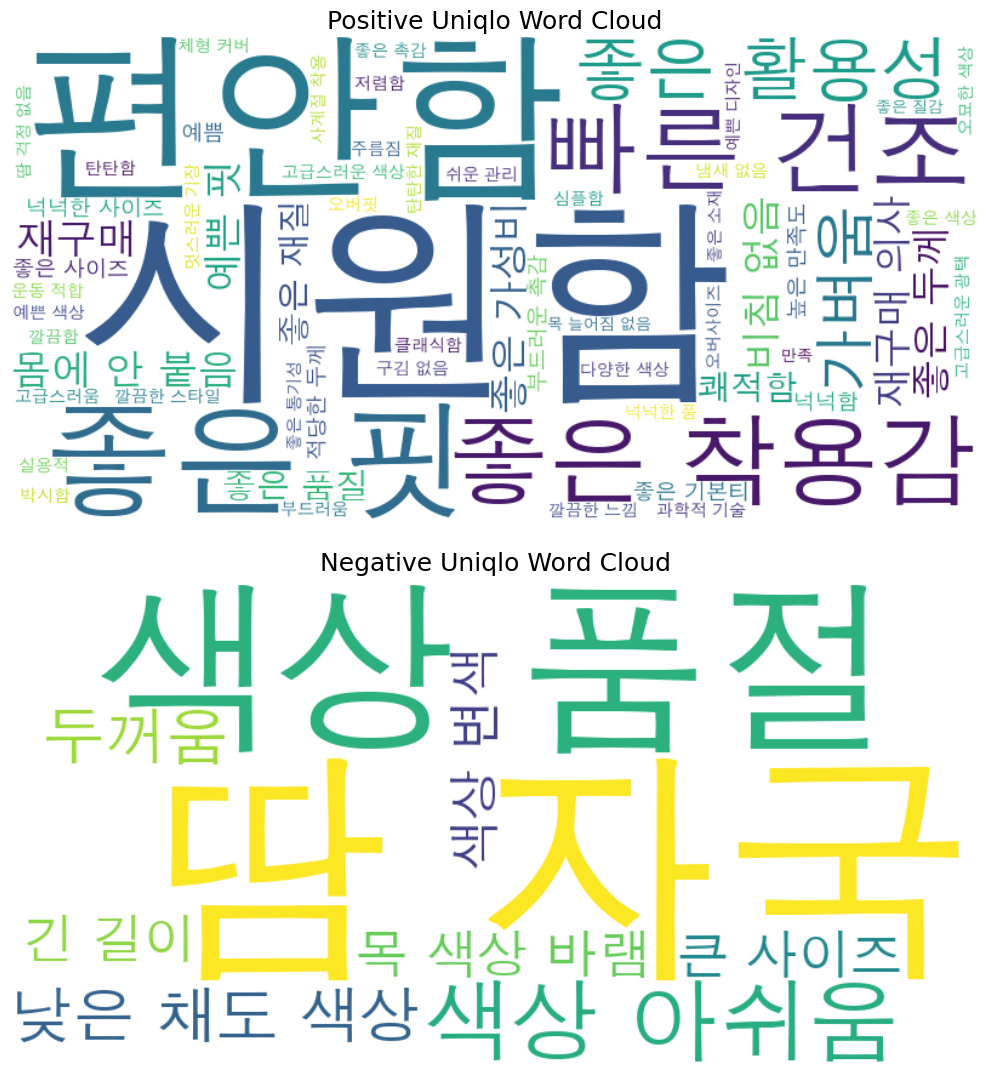

In [46]:
wordcloud_neg = WordCloud(
    font_path='/Library/Fonts/AppleGothic.ttf',
    background_color='white',
    width=800,
    height=400,
    max_words=200
).generate_from_frequencies(Counter(negative_words))

wordcloud_pos = WordCloud(
    font_path='/Library/Fonts/AppleGothic.ttf',
    background_color='white',
    width=800,
    height=400,
    max_words=200
).generate_from_frequencies(Counter(positive_words))

# subplot으로 표시 (2행 1열)
plt.figure(figsize=(10, 11))

# Positive 워드클라우드
plt.subplot(2, 1, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Uniqlo Word Cloud', fontsize=18)

# Negative 워드클라우드
plt.subplot(2, 1, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Uniqlo Word Cloud', fontsize=18)

plt.tight_layout()
plt.show()